Failed to initialize Logging:  [WinError 32] The process cannot access the file because it is being used by another process: './00-FORENSIC_LOG.txt'

File Feature Extraction
Version 1.0
Author: C. Hosmer, Python Forensics

Note: Script assumes file extensions are correct

Enter Starting Path: C:\Program Files (x86)
.......................................................................................................................................................................................................................................................................................


Tabulating Results


Top Rows
     Size  Rank Modified                Header  Type       FileType
0     174    14     Year  18446195417575086848     7  Configuration
1   16633    12      Old   4352857053167908973     5       Document
2  328240    16     Year   5573925818549141504     4     Executable
3  186837   462      Old   2688724045736783413     5       Document
4  168496    16     Year   5573

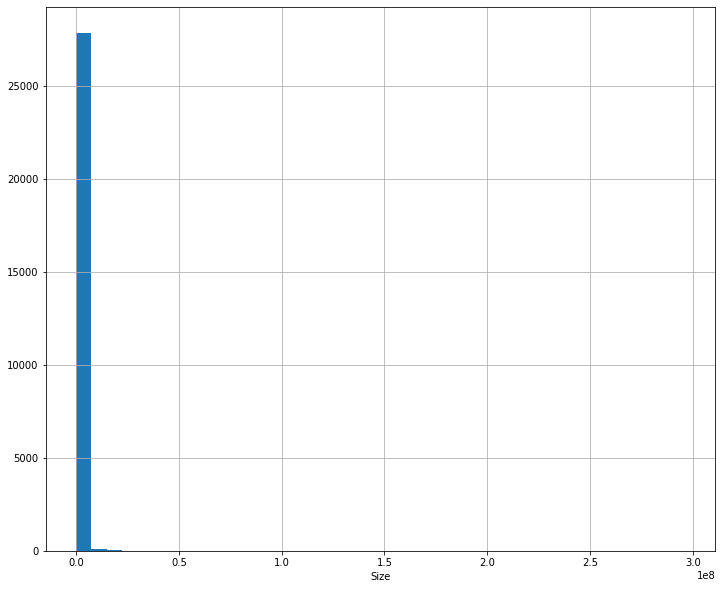

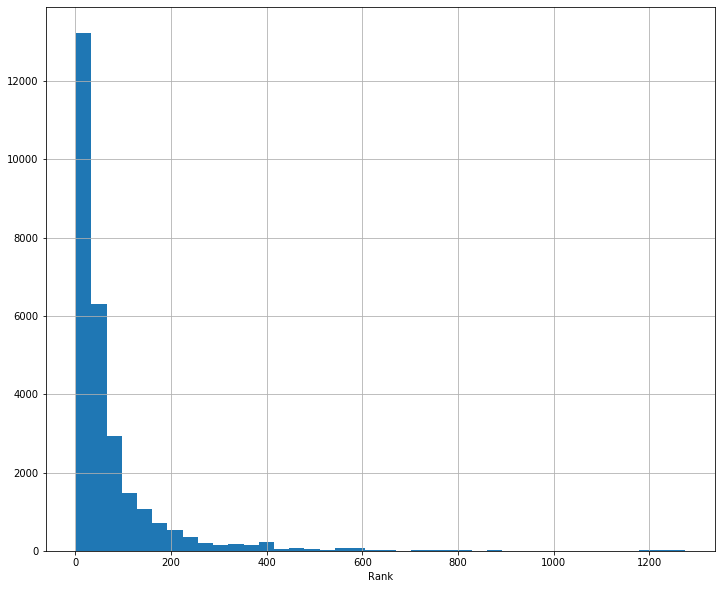

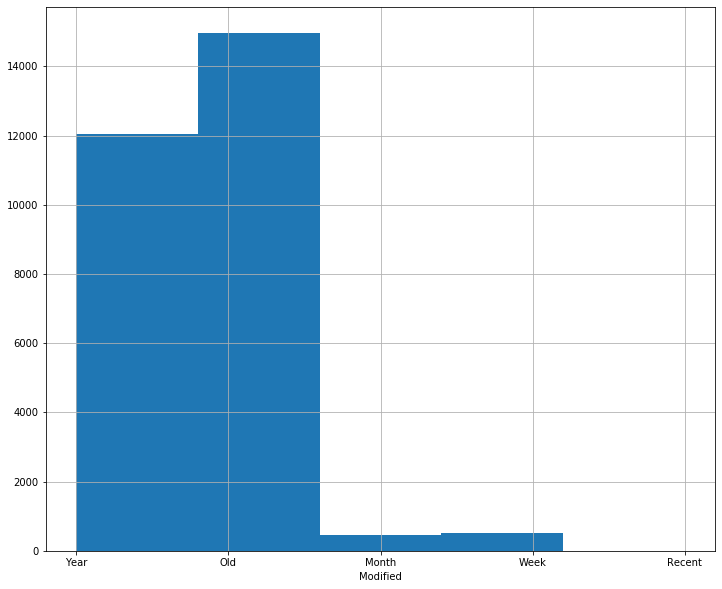

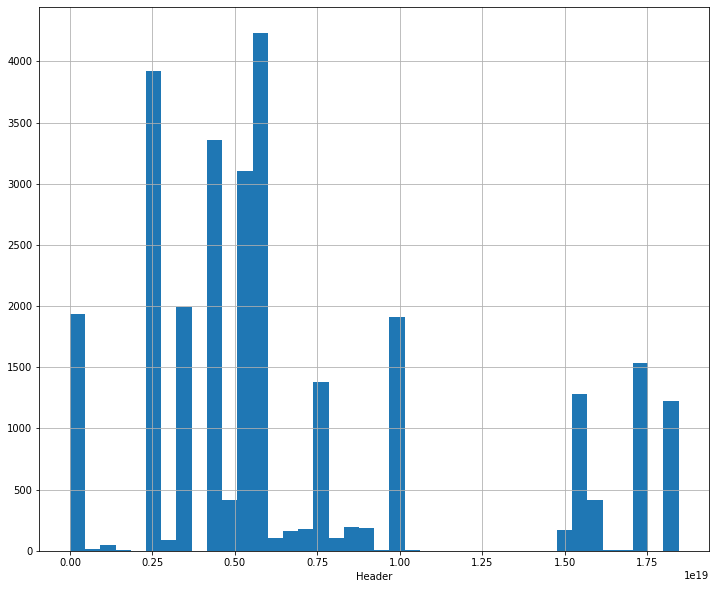

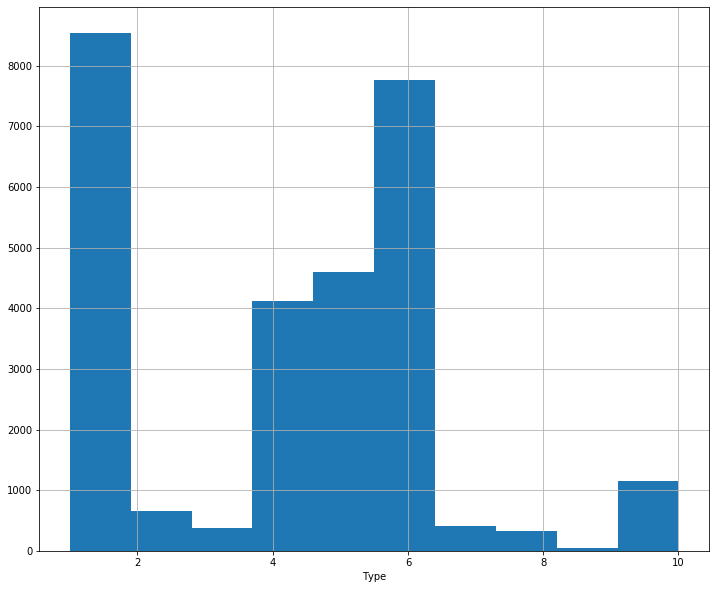

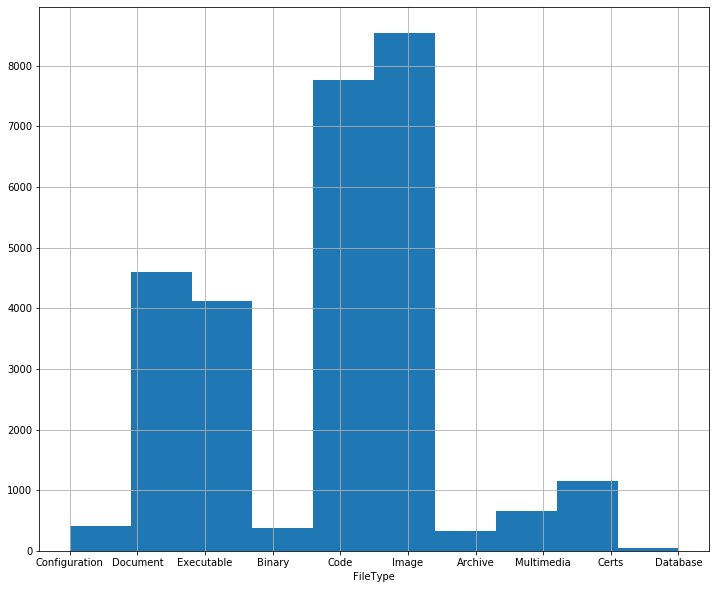



Script Completed


In [2]:
'''
Copyright (c) Chet Hosmer 2019-2020

Permission is hereby granted, free of charge, to any person obtaining a copy of this software
and associated documentation files (the "Software"), to deal in the Software without restriction, 
including without limitation the rights to use, copy, modify, merge, publish, distribute, sublicense, 
and/or sell copies of the Software, and to permit persons to whom the Software is furnished to do so, 
subject to the following conditions:

Objective to develop a model for file type FileType by examining specific features of
known files (that are properly labeled by extension).  Then to experiment with several machine
learning algorthims that will identify unknown files and classify there general types.

The initial FileType are:

Images
Multimedia
Generic Binary
Executable
Documents
Code
Archive
Database
Certs

The initial set of features or characteristics include:

File Size
File Name Complexity
File Age
File Header (First 8 bytes)

'''

# Script Module Importing

# Python Standard Library Modules
import os           # Operating/Filesystem Module
import time         # Basic Time Module
import logging      # Script Logging
import struct       # Binary Structure
import sys          # System Specifics

# Import 3rd Party Modules

from pandas import DataFrame as df
import matplotlib.pyplot as plt

PRETTY_TABLE   = False
CSV_FILE       = False

if PRETTY_TABLE:
    from prettytable import PrettyTable

# End of Script Module Importing


# Script Constants

'''
Python does not support constants directly
however, by initializing variables here and
specifying them as UPPER_CASE you can make your
intent known
'''
# General Constants
SCRIPT_NAME    = "File Feature Extraction"
SCRIPT_VERSION = "Version 1.0"
SCRIPT_AUTHOR  = "Author: C. Hosmer, Python Forensics"
SCRIPT_LOG     = "./00-FORENSIC_LOG.txt"



# LOG Constants used as input to LogEvent Function
LOG_DEBUG = 0           # Debugging Event
LOG_INFO  = 1           # Information Event
LOG_WARN  = 2           # Warning Event
LOG_ERR   = 3           # Error Event
LOG_CRIT  = 4           # Critical Event
LOG_OVERWRITE = True    # Set this contstant to True if the SCRIPT_LOG
                        # should be overwritten, False if not

# End of Script Constants


# Initialize the Forensic Log

try:            
    # If LOG should be overwritten before
    # each run, the remove the old log
    if LOG_OVERWRITE:
        # Verify that the log exists before removing
        if os.path.exists(SCRIPT_LOG):
            os.remove(SCRIPT_LOG)

    # Initialize the Log include the Level and message
    logging.basicConfig(filename=SCRIPT_LOG, format='%(levelname)s\t:%(message)s', level=logging.DEBUG)

except Exception as err:
    print("Failed to initialize Logging: ", err)
    quit()

# End of Forensic Log Initialization

# Script Functions
'''
If you script will contain functions then insert them
here, before the execution of the main script.  This
will ensure that the functions will be callable from
anywhere in your script
'''

# Function: GetTime()
#
# Returns a string containing the current time
#
# Script will use the local system clock, time, date and timezone
# to calcuate the current time.  Thus you should sync your system
# clock before using this script
#
# Input: timeStyle = 'UTC', 'LOCAL', the function will default to 
#                    UTC Time if you pass in nothing.

def GetTime(timeStyle = "UTC"):

    if timeStyle == 'UTC':
        return ('UTC Time:  ', time.asctime(time.gmtime(time.time()))) 
    elif timeStyle == 'LOCAL':
        return ('Local Time:', time.asctime(time.localtime(time.time())))
    else:
        return "Invalid TimeStyle Specified"
    
# End GetTime Function       


# Function: LogEvent()
#
# Logs the event message and specified type
# Input: 
#        eventType: LOG_INFO, LOG_WARN, LOG_ERR, LOG_CRIT or LOG_DEBUG
#        eventMessage : string containing the message to be logged


def LogEvent(eventType, eventMessage):

    if type(eventMessage) == str:
        try:

            timeStr = GetTime('UTC')
            # Combine current Time with the eventMessage
            # You can specify either 'UTC' or 'LOCAL'
            # Based on the GetTime parameter

            eventMessage = str(timeStr)+": "+eventMessage

            if eventType == LOG_INFO:
                logging.info(eventMessage)

            elif eventType == LOG_DEBUG:
                logging.debug(eventMessage)

            elif eventType == LOG_WARN:
                logging.warning(eventMessage)

            elif eventType == LOG_ERR:
                logging.error(eventMessage)

            elif eventType == LOG_CRIT:
                logging.critical(eventMessage)

            else:
                logging.info(eventMessage)
        except:
            print("Event Logging Failed")
    else:
        logging.warn('Received invalid event message')

# End LogEvent Function   


def SavePrettyTable(pTable, csvFile):
    """Save PrettyTable results to a CSV file.
    :param pTable table: Table object to get data from.
    :param str csvRile: Filepath for the output CSV.
    :return: True on Success, False and Fail
    """
     
    try:   
        raw = pTable.get_string()
        rows = [tuple(filter(None, map(str.strip, splitline)))
                for line in raw.splitlines()
                for splitline in [line.split('|')] if len(splitline) > 1]
    
        with open(csvFile, 'w') as outFile:
            for eachRow in rows:
                outFile.write('{}\n'.format(','.join(eachRow)))
        return True
    except Exception as err:
        return False


# End of Script Functions

# Script Classes
'''
If you script will contain classes then insert them
here, before the execution of the main script.  This
will ensure that the functions will be accessible from
anywhere in your script
'''

# End of Script Classes


# Main Script Starts Here

if __name__ == '__main__':
    
    LogEvent(LOG_INFO, SCRIPT_NAME)
    LogEvent(LOG_INFO, SCRIPT_VERSION)
    LogEvent(LOG_INFO, "Script Started")
    
    # Current File Type Extenstion List
    imgList  = [".jpg", ".jpeg", ".bmp", ".cur", ".wmf", ".gif", ".png", ".ogg", ".ico", ".ttf", ".svg", ".cmap", "xttf", "xeps", ".mac", ".psd", ".plt", ".tif", ".tiff", ".clips"]
    mmList   = [".mp4", ".mp3", ".avi", ".wav", ".swf", ".xmc", ".aif", ".aiff", "au", ".mov", ".qt", ".mid", ".midi", ".stx", ".lng"]
    docList  = [".xls", ".xlsx", ".doc", ".docx", ".dotx", ".xsl", ".xsd", ".cat", ".xslt", ".log", ".man", ".inx", ".micl", ".rtf", ".json", ".ppt", ".pptx",".csv", ".txt", ".url", ".pdf", ".p65", ".dat", ".htm", ".nse", ".lst", ".template", ".wk3", ".wks", ".wpd", ".wp5"]
    exeList  = [".exe", ".dll", ".bat", ".mui", ".msi", ".mo", ".crx", ".rll", ".sh", ".rsc", ".cmd", ".mst"]
    binList  = [".bin", ".raw", ".mem", ".pf", ".pma"]
    confList = [".config", ".conf", ".ini", ".inf", "stx", ".cfg", ".properties"]
    codeList = [".py", ".pyo", ".pyi", ".ps1", ".pi", ".pyc", ".pxd", ".pyd", ".qml", ".qmltypes", ".c", ".api", ".tlb", ".so", ".scheme", ".lua", ".c#", ".cpp", ".c++", ".class", ".perl", ".pl", ".php", ".pas", ".vb", ".java", ".js", ".jar", ".jsp", ".html", ".css", ".rb", ".xml", ".qm"]
    arcList  = [".zip", ".ar", ".tar", ".chm", ".arc", ".arj", ".cab", ".egg", ".whl", ".dmg", ".lha", ".gzip", ".rar", ".pak", ".sit", ".xpi", ".diz"]
    dbList   = [".db", ".db", ".dbf", ".mdb", ".dmd", ".sql", ".sqld"]
    certList = [".xrm-ms"]
    
    # Print Basic Script Information
    print()
    print(SCRIPT_NAME)
    print(SCRIPT_VERSION)
    print(SCRIPT_AUTHOR)
    
    if PRETTY_TABLE:
        # Create a table and heading if wanted
        tbl = PrettyTable(['Name', 'Size', 'NameRank', 'Modified', 'Header','FileTypeCode','FileType', ])    
    
    # Prompt user for Known Good Starting Path
    print("\nNote: Script assumes file extensions are correct\n")
    myRoot = input("Enter Starting Path: ")
    
    if os.path.isdir(myRoot):
        myRoot = os.path.abspath(myRoot)
        LogEvent(LOG_INFO, "Starting Path: "+myRoot)
    else:
        sys.exit("\n\nPath is not a directory ... Script Exit\n\n")

    # Use the os.walk method to walk the path from
    # root to bottom
    
    fileList = []
    totalFiles = 0
    completion = 0
    for root, dirs, files in os.walk(myRoot):
        totalFiles = totalFiles + len(files)
        
    filesProcessed  = 0
    for root, dirs, files in os.walk(myRoot):
    
        # Walk the path from top to bottom.
        # For each file obtain extract key features
        
        for eachFile in files:
            
            try:
                baseName  = eachFile
                baseNameWithOutExt = os.path.splitext(baseName)[0]
                
                # Calculate name complexity
                alphCnt = 0
                numCnt  = 0
                spcCnt  = 1
                totCnt  = 0
                
                for eachLetter in baseNameWithOutExt:
                    eachLetter = str(eachLetter)
                    totCnt+=1
                    if eachLetter.isalpha():
                        alphCnt += 1
                    elif eachLetter.isnumeric():
                        numCnt += 1
                    else:
                        spcCnt += 1
                
                try:
                    nameRank = (totCnt+alphCnt+numCnt)*spcCnt
                except:
                    continue
                    
                ext       = os.path.splitext(baseName)[1]
                
                # Classify the file based only on extension 
                # Make sure this is from a known good source
                if ext.lower() in imgList:
                    FileType = "Image"
                    cValue = 1
                elif ext.lower() in mmList:
                    FileType = "Multimedia"
                    cValue = 2
                elif ext.lower() in binList:
                    FileType = "Binary"   
                    cValue = 3
                elif ext.lower() in exeList:
                    FileType = "Executable"  
                    cValue = 4
                elif ext.lower() in docList:
                    FileType = "Document"  
                    cValue = 5
                elif ext.lower() in codeList:
                    FileType = "Code"   
                    cValue = 6
                elif ext.lower() in confList:
                    FileType = "Configuration"   
                    cValue = 7
                elif ext.lower() in arcList:
                    FileType = "Archive"    
                    cValue = 8
                elif ext.lower() in dbList:
                    FileType = "Database"     
                    cValue = 9
                elif ext.lower() in certList:
                    FileType = "Certs"        
                    cValue = 10
                else:
                    FileType = "Undefined"
                    cValue = 11
                    continue
                    
                relativePath = os.path.join(root, eachFile)
                absPath = os.path.abspath(relativePath)
                stats = os.stat(absPath)
                sz = stats.st_size
    
                # Classify the age of the file by last modified date
                oneDay = 60*60*24
                
                now = time.time()
                modTime = stats.st_mtime
                diff = now -modTime
                
                if diff <= oneDay:
                    mod = "Recent"
                elif diff <= oneDay * 7:
                    mod = "Week"
                elif diff <= oneDay * 30:
                    mod = "Month"         
                elif diff <= oneDay * 356:
                    mod = "Year"
                else:
                    mod = "Old"
                
                # Extract the file header and store it as 
                # an unsigned long long integer
                with open(absPath, 'rb') as inFile:
                    contents  = inFile.read(8)
                    hdrValue = struct.unpack('>Q', contents)
                
                filesProcessed += 1
                
                if filesProcessed >= 100:
                    print(".", end='')
                    filesProcessed = 0
                
                # Append the current file observations
                fileList.append((sz, nameRank, mod, hdrValue[0], cValue, FileType))
                
                # If pretty table generation is selected add a row
                if PRETTY_TABLE:
                    tbl.add_row([baseName, sz, nameRank, mod, hdrValue[0], cValue, FileType])
                    
            except Exception as err:
                continue
    
    # Capture complete - Now create the panda dataframe fa
    print("\n\n\nTabulating Results\n\n")
    fa = df(fileList, columns=['Size', 'Rank', 'Modified', 'Header', 'Type', 'FileType'])
    
    # Display some basic dataframe information
    print("Top Rows")
    print(fa.head())
    
    print("\nInfo")
    print(fa.info())    

    print("\nData Types")
    print(fa.dtypes)
    
    # Generate Histograms for each of the fields
    print("\nGenerating Histograms")
    
    for f in fa.columns:
        try:
            fig = plt.figure(figsize=(12, 10), num="File Attribute Histogram")
            num_bins = min((40, len(fa[f].unique())))
            fa[f].hist(bins=num_bins)
            plt.xlabel(f)
            plt.show()
        except TypeError:
            print()
            print(fa[f].value_counts())
            print('-'*30)
                
    # Generate pretty table results if selected
    if PRETTY_TABLE:   
        tbl.align = "l" 
        print(tbl.get_string(sortby='FileType'))
        
        # Store the pretty table results as a CSV file if selected
        if CSV_FILE:
            if SavePrettyTable(tbl, 'baseline.csv'):
                print("CSV File: baseline.csv created")
            else:
                print("CSV File Creation Failed")
            
        LogEvent(LOG_INFO,  'Script Ended')

print("\n\nScript Completed");
# End of Script Main

    
